# Objective

fine-tune a pre-trained BERT model to perform sentiment analysis on a twitter data.

# Table of Contents

1. Setup
  - Using Google Colab for training
  - Installing the Hugging Face's Transformers Library
2. Loading & Understanding BERT
  - Download Pretrained BERT model
3. Preparing Data
  - Loading and Reading Twitter Airline
  - Text Cleaning
  - Preparing Input and Output Data
  - Training and Validation Data
  - Define Dataloaders
4. Model Finetuning
  - Approach: Fine-Tuning Only Head
  - Define Model Architecture
  - Define Optimizer and Loss function
  - Model Training and Evaluation
  - Train the Model
  - Model Evaluation 


# 1. Setup


In [2]:
#import torch library
import torch

## 1.2. Installing the Hugging Face's Transformers Library

Hugging Face 🤗 is the one of the most popular Natural Language Processing communities for deep learning researchers, hands-on practitioners and educators. It provides State of Art architectures for everyone.


In [ ]:
#install hugging face transformers
!pip install transformers

     |████████████████████████████████| 3.4 MB 5.4 MB/s 
     |████████████████████████████████| 895 kB 58.1 MB/s 
     |████████████████████████████████| 3.3 MB 42.7 MB/s 
     |████████████████████████████████| 596 kB 54.1 MB/s 
     |████████████████████████████████| 61 kB 396 kB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 2. Loading & Understanding BERT 

##2.1 Download Pretrained BERT model

We will use the uncased pre-trained version of the BERT base model. It was trained on lower-cased English text. 

In [ ]:
from transformers import BertModel

# download bert pretrained model
bert = BertModel.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# print bert architecture
print(bert)

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

##2.2 Tokenization
**Download BERT Tokenizer**


In [ ]:
#importing fast "BERT" tokenizer
from transformers import BertTokenizerFast

# Load BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased', do_lower_case=True)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

#3. Preparing Data




##3.1 Loading and Reading Twitter Airline 

In [ ]:
# upload the data and extract the file
!unzip 'Airline_Tweets.zip'

Archive:  Airline_Tweets.zip
  inflating: Tweets.csv              


In [ ]:
import pandas as pd

# increase the output column width
pd.set_option('display.max_colwidth', 200)

# read CSV file
df = pd.read_csv('/content/drive/MyDrive/Airline_Tweets-200904-165552/Tweets.csv')

# print first 5 rows
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials to the experience... tacky.,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I need to take another trip!,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing about it,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [ ]:
#shape of the dataframe
df.shape

(14640, 15)

In [ ]:
df['text'].head()

0                                                                                               @VirginAmerica What @dhepburn said.
1                                                          @VirginAmerica plus you've added commercials to the experience... tacky.
2                                                           @VirginAmerica I didn't today... Must mean I need to take another trip!
3    @VirginAmerica it's really aggressive to blast obnoxious "entertainment" in your guests' faces &amp; they have little recourse
4                                                                           @VirginAmerica and it's a really big bad thing about it
Name: text, dtype: object

In [ ]:
# class distribution
df['airline_sentiment'].value_counts()

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

In [ ]:
# class distribution
df['airline_sentiment'].value_counts(normalize = True)

negative    0.626913
neutral     0.211680
positive    0.161407
Name: airline_sentiment, dtype: float64

In [ ]:
# saving the value counts to a list
class_counts = df['airline_sentiment'].value_counts().tolist()

##3.2 Text Cleaning

In [ ]:
#library for pattern matching
import re

#define a function for text cleaning
def preprocessor(text):
  
  #convering text to lower case
  text = text.lower()

  #remove user mentions
  text = re.sub(r'@[A-Za-z0-9]+','',text)           
  
  #remove hashtags
  #text = re.sub(r'#[A-Za-z0-9]+','',text)         
  
  #remove links
  text = re.sub(r'http\S+', '', text)  
  
  #split token to remove extra spaces
  tokens = text.split()
  
  #join tokens by space
  return " ".join(tokens)

In [ ]:
# perform text cleaning
df['clean_text']= df['text'].apply(preprocessor)

In [ ]:
# save cleaned text and labels to a variable
text   = df['clean_text'].values
labels = df['airline_sentiment'].values

In [ ]:
type(text)

numpy.ndarray

In [ ]:
#cleaned text
text[50:55]

array(['is flight 769 on it\'s way? was supposed to take off 30 minutes ago. website still shows "on time" not "in flight". thanks.',
       'julie andrews all the way though was very impressive! no to',
       'wish you flew out of atlanta... soon?',
       'julie andrews. hands down.',
       'will flights be leaving dallas for la on february 24th?'],
      dtype=object)

##3.3 Preparing Input and Output Data


**Preparing Output**

In [ ]:
#importing label encoder
from sklearn.preprocessing import LabelEncoder

#define label encoder
le = LabelEncoder()

#fit and transform target strings to a numbers
labels = le.fit_transform(labels)

In [ ]:
#classes
le.classes_

array(['negative', 'neutral', 'positive'], dtype=object)

In [ ]:
labels

array([1, 2, 1, ..., 1, 0, 1])

**Preparing Input Data**

Text(0.5, 1.0, 'Histogram: Length of sentences')

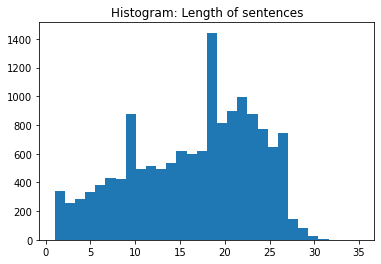

In [ ]:
# library for visualization
import matplotlib.pyplot as plt

# compute no. of words in each tweet
num = [len(i.split()) for i in text]

plt.hist(num, bins = 30)

plt.title("Histogram: Length of sentences")

In [ ]:
# define maximum length of a text
max_len = 25

In [ ]:
# library for progress bar
from tqdm import notebook
'''from transformers import BertModel,BertTokenizerFast
bert=BertModel.from_pretrained('bert-base-uncased')
# Load BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased', do_lower_case=True) '''
# create an empty list to save integer sequence
sent_id = []

# iterate over each tweet
for i in notebook.tqdm(range(len(text))):
  
  encoded_sent = tokenizer.encode(text[i],                      
                                  add_special_tokens = True,    
                                  max_length = max_len,
                                  truncation = True,         
                                  pad_to_max_length='right')    
  
  # saving integer sequence to a list
  sent_id.append(encoded_sent)

  0%|          | 0/14640 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2232: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
print("Integer Sequence:",sent_id[0])

Integer Sequence: [101, 2054, 2056, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [ ]:
# create attention masks
attention_masks = []

# for each sentence...
for sent in sent_id:
  att_mask = [int(token_id > 0) for token_id in sent]
  
  # store the attention mask for this sentence.
  attention_masks.append(att_mask)

##3.4 Training and Validation Data

In [ ]:
# Use train_test_split to split our data into train and validation sets
from sklearn.model_selection import train_test_split

# Use 90% for training and 10% for validation.
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(sent_id, labels, random_state=2018, test_size=0.1, stratify=labels)

# Do the same for the masks.
train_masks, validation_masks, _, _ = train_test_split(attention_masks, labels, random_state=2018, test_size=0.1, stratify=labels)

##3.5 Define Dataloaders



In [ ]:
# Convert all inputs and labels into torch tensors, the required datatype for our model.
import torch
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)

train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it here.
# For fine-tuning BERT on a specific task, the authors recommend a batch size of 16 or 32.

#define a batch size
batch_size = 32

# Create the DataLoader for our training set.
#Dataset wrapping tensors.
train_data = TensorDataset(train_inputs, train_masks, train_labels)

#define a sampler for sampling the data during training
  #random sampler samples randomly from a dataset 
  #sequential sampler samples sequentially, always in the same order
train_sampler = RandomSampler(train_data)

#represents a iterator over a dataset. Supports batching, customized data loading order
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set.
#Dataset wrapping tensors.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)

#define a sequential sampler 
#This samples data in a sequential order
validation_sampler = SequentialSampler(validation_data)

#create a iterator over the dataset
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [ ]:
#create an iterator object
iterator = iter(train_dataloader)

#loads batch data
sent_id, mask, target=iterator.next()

In [ ]:
target.shape

torch.Size([32])

In [ ]:
sent_id

tensor([[  101,  2005,  2026, 13055, 11713,  1005,  1055,  3770,  2705,  1010,
          2016,  2052,  2293,  1037,  5798, 14806,  2013,  2115,  3462,  3626,
           999,  2016,  2001,  1037,   102],
        [  101, 15278,  1010,  7394,  1011,  2000,  3745,  2026,  2293,  1997,
          5855,  1998,  2681,  4620,  2369,  1010,  2004,  2092,  2004,  2000,
          8116,  2172,  1011,  2734,   102],
        [  101,  2065,  2026,  3462,  4152,  8014,  3462,  3709,  1045,  2323,
          2022,  2583,  2000, 24501,  7690,  9307,  2000,  2151,  3058,  1045,
          2215,  1010,  2025,  1996,   102],
        [  101,  1045,  1040,  7583,   102,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0],
        [  101,  2129,  2272,  5925,  2003,  1996,  2069,  2028,  1997,  1996,
          2897,  6833,  2017,  2123,  1005,  1056,  2031,  1029,   102,     0,
             0,     0,     0, 

In [ ]:
#pass inputs to the model
outputs = bert(sent_id,             #integer sequence
               attention_mask=mask) #attention masks

In [ ]:
# hidden states
hidden_states = outputs[0]

# [CLS] hidden state
CLS_hidden_state = outputs[1]

print("Shape of Hidden States:",hidden_states.shape)
print("Shape of CLS Hidden State:",CLS_hidden_state.shape)

Shape of Hidden States: torch.Size([32, 25, 768])
Shape of CLS Hidden State: torch.Size([32, 768])


#4. Model Finetuning 



### 4.1 Approach: Fine-Tuning Only Head

We freeze the backbone and train only the head or dense layer.

### Steps to Follow

1. Turn off Gradients

2. Define Model Architecture

3. Define Optimizer and Loss

4. Define Train and Evaluate

5. Train the model

6. Evaluate the model




In [ ]:
# turn off the gradient of all the parameters
for param in bert.parameters():
    param.requires_grad = False

##4.2 Define Model Architecture


In [ ]:
#importing nn module
import torch.nn as nn

class classifier(nn.Module):

    #define the layers and wrappers used by model
    def __init__(self, bert):
      
      #constructor
      super(classifier, self).__init__()

      #bert model
      self.bert = bert 

      # dense layer 1
      self.fc1 = nn.Linear(torch.tensor(768),512)
      
      #dense layer 2 (Output layer)
      self.fc2 = nn.Linear(512,3)
      
      #dropout layer
      self.dropout = nn.Dropout(0.1)

      #relu activation function
      self.relu =  nn.ReLU()

      #softmax activation function
      self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

      #pass the inputs to the model  
      all_hidden_states, cls_hidden_state = self.bert(sent_id, attention_mask=mask,return_dict=False)
      
      #pass CLS hidden state to dense layer
      x = self.fc1(cls_hidden_state)

      #Apply ReLU activation function
      x = self.relu(x)

      #Apply Dropout
      x = self.dropout(x)

      #pass input to the output layer
      x = self.fc2(x)
      
      #apply softmax activation
      x = self.softmax(x)

      return x

In [ ]:
#create the model
model = classifier(bert)


In [ ]:
#model architecture 
model

classifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
 

In [ ]:
type(mask)

torch.Tensor

In [ ]:
sent_id=torch.tensor(sent_id)

# pass inputs to the model
outputs = model(sent_id, mask)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """


In [ ]:
# understand outputs
#print(len(outputs)) #32
print(outputs)

tensor([[-1.1652, -0.9820, -1.1597],
        [-1.1828, -0.9959, -1.1263],
        [-1.2052, -0.9846, -1.1184],
        [-1.1434, -1.0976, -1.0566],
        [-1.1218, -1.0842, -1.0902],
        [-1.1194, -1.0819, -1.0949],
        [-1.1703, -0.9967, -1.1375],
        [-1.1821, -0.9621, -1.1671],
        [-1.0608, -1.0814, -1.1561],
        [-1.1195, -0.9849, -1.2037],
        [-1.1115, -1.0678, -1.1173],
        [-1.1351, -1.0012, -1.1675],
        [-1.0588, -1.0744, -1.1659],
        [-1.2294, -0.8940, -1.2090],
        [-1.2370, -0.9246, -1.1614],
        [-1.1855, -0.9738, -1.1496],
        [-1.1773, -0.9289, -1.2144],
        [-1.1335, -1.0668, -1.0966],
        [-1.1497, -1.0086, -1.1440],
        [-1.1230, -1.0636, -1.1102],
        [-1.2821, -0.8724, -1.1887],
        [-1.1373, -0.9824, -1.1878],
        [-1.1408, -1.0756, -1.0808],
        [-1.0879, -1.1231, -1.0853],
        [-1.1245, -0.9922, -1.1894],
        [-1.2174, -0.9280, -1.1756],
        [-1.1836, -0.9812, -1.1427],
 

In [ ]:
# no. of trianable parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 395,267 trainable parameters


## 4.3 Define Optimizer and Loss function


In [ ]:
# Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

Text(0.5, 1.0, 'Class Distribution')

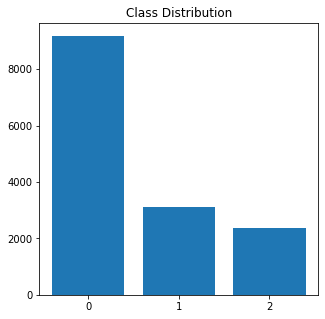

In [ ]:
# understand the class distribution
keys=['0','1','2']

# set figure size
plt.figure(figsize=(5,5))

# plot bat chart
plt.bar(keys,class_counts)

# set title
plt.title('Class Distribution')

In [ ]:
#library for array processing
import numpy as np

#library for computing class weights
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)

print("Class Weights:",class_weights)

Class Weights: [0.53170625 1.57470152 2.06517139]


In [ ]:
import torch
# converting a list of class weights to a tensor
weights= torch.tensor(class_weights,dtype=torch.float)

# define the loss function
cross_entropy  = nn.NLLLoss(weight=weights) 

In [ ]:
#compute the loss
loss = cross_entropy(outputs, target)
print("Loss:",loss)

Loss: tensor(1.0935, grad_fn=<NllLossBackward0>)


In [ ]:
import time
import datetime

# compute time in hh:mm:ss
def format_time(elapsed):
    # round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # format as hh:mm:ss
    return str(datetime.timedelta(seconds = elapsed_rounded))

## 4.4 Model Training and Evaluation


During training, for each batch, we need to

1. Perform Forward Pass
2. Compute Loss
3. Backpropagate Loss
4. Update Weights 

Where as during evaluation, for each batch, we need to

1. Perform forward pass
2. Compute loss




In [ ]:
#define a function for training the model
def train():
  
  print("\nTraining.....")  
  
  #set the model on training phase - Dropout layers are activated
  model.train()

  #record the current time
  t0 = time.time()

  #initialize loss and accuracy to 0
  total_loss, total_accuracy = 0, 0
  
  #Create a empty list to save the model predictions
  total_preds=[]
  
  #for every batch
  for step,batch in enumerate(train_dataloader):
    
    # Progress update after every 40 batches.
    if step % 40 == 0 and not step == 0:
      
      # Calculate elapsed time in minutes.
      elapsed = format_time(time.time() - t0)
            
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))


    # `batch` contains three pytorch tensors:
    #   [0]: input ids 
    #   [1]: attention masks
    #   [2]: labels 
    sent_id, mask, labels = batch


    model.zero_grad()        

    # Perform a forward pass. This returns the model predictions
    preds = model(sent_id, mask)

    #compute the loss between actual and predicted values
    loss =  cross_entropy(preds, labels)

    # Accumulate the training loss over all of the batches so that we can
    # calculate the average loss at the end. `loss` is a Tensor containing a
    # single value; the `.item()` function just returns the Python value 
    # from the tensor.
    total_loss = total_loss + loss.item()

    # Perform a backward pass to calculate the gradients.
    loss.backward()

    # Update parameters and take a step using the computed gradient.
    # The optimizer dictates the "update rule"--how the parameters are
    # modified based on their gradients, the learning rate, etc.
    optimizer.step()

    #The model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    #Accumulate the model predictions of each batch
    total_preds.append(preds)

  #compute the training loss of a epoch
  avg_loss     = total_loss / len(train_dataloader)
  
  #The predictions are in the form of (no. of batches, size of batch, no. of classes).
  #So, reshaping the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss, total_preds


**Evaluation phase**




In [ ]:
#define a function for evaluating the model
def evaluate():
  
  print("\nEvaluating.....")
  
  #set the model on training phase - Dropout layers are deactivated
  model.eval()

  #record the current time
  t0 = time.time()

  #initialize the loss and accuracy to 0
  total_loss, total_accuracy = 0, 0
  
  #Create a empty list to save the model predictions
  total_preds = []

  #for each batch  
  for step,batch in enumerate(validation_dataloader):
    
    # Progress update every 40 batches.
    if step % 40 == 0 and not step == 0:
      
      # Calculate elapsed time in minutes.
      elapsed = format_time(time.time() - t0)
            
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(validation_dataloader), elapsed))


    #unpack the batch into separate variables
    # `batch` contains three pytorch tensors:
    #   [0]: input ids 
    #   [1]: attention masks
    #   [2]: labels        
    sent_id, mask, labels = batch

    #deactivates autograd
    with torch.no_grad():
      
      # Perform a forward pass. This returns the model predictions
      preds = model(sent_id, mask)

      #compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)

      # Accumulate the validation loss over all of the batches so that we can
      # calculate the average loss at the end. `loss` is a Tensor containing a
      # single value; the `.item()` function just returns the Python value 
      # from the tensor.      
      total_loss = total_loss + loss.item()

      #The model predictions are stored on GPU. So, push it to CPU
      preds=preds.detach().cpu().numpy()

      #Accumulate the model predictions of each batch
      total_preds.append(preds)

  #compute the validation loss of a epoch
  avg_loss = total_loss / len(validation_dataloader) 

  #The predictions are in the form of (no. of batches, size of batch, no. of classes).
  #So, reshaping the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

##4.5 Train the Model

In [ ]:
#Assign the initial loss to infinite
best_valid_loss = float('inf')

#create a empty list to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

epochs = 5

#for each epoch
for epoch in range(epochs):
     
    print('\n....... epoch {:} / {:} .......'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train()
    
    #evaluate model
    valid_loss, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    #accumulate training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')

print("")
print("Training complete!")


....... epoch 1 / 5 .......

Training.....
  Batch    40  of    412.    Elapsed: 0:01:43.
  Batch    80  of    412.    Elapsed: 0:03:29.
  Batch   120  of    412.    Elapsed: 0:05:14.
  Batch   160  of    412.    Elapsed: 0:06:58.
  Batch   200  of    412.    Elapsed: 0:08:42.
  Batch   240  of    412.    Elapsed: 0:10:24.
  Batch   280  of    412.    Elapsed: 0:12:05.
  Batch   320  of    412.    Elapsed: 0:13:48.
  Batch   360  of    412.    Elapsed: 0:15:30.
  Batch   400  of    412.    Elapsed: 0:17:10.

Evaluating.....
  Batch    40  of     46.    Elapsed: 0:01:38.

Training Loss: 0.989
Validation Loss: 0.860

....... epoch 2 / 5 .......

Training.....
  Batch    40  of    412.    Elapsed: 0:01:45.
  Batch    80  of    412.    Elapsed: 0:03:30.
  Batch   120  of    412.    Elapsed: 0:05:15.
  Batch   160  of    412.    Elapsed: 0:07:00.
  Batch   200  of    412.    Elapsed: 0:08:43.
  Batch   240  of    412.    Elapsed: 0:10:25.
  Batch   280  of    412.    Elapsed: 0:12:07.
  Ba

##4.6 Model Evaluation

In [ ]:
# load weights of best model
path='saved_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [ ]:
# get the model predictions on the validation data
# returns 2 elements- Validation loss and Predictions
valid_loss, preds = evaluate()
print(valid_loss)


Evaluating.....
  Batch    40  of     46.    Elapsed: 0:01:55.
0.6654885106760523


In [ ]:
# Converting the log(probabities) into a classes
# Choosing index of a maximum value as class
y_pred = np.argmax(preds,axis=1)

# actual labels
y_true = validation_labels

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true,y_pred))

              precision    recall  f1-score   support

           0       0.87      0.80      0.83       918
           1       0.60      0.53      0.56       310
           2       0.56      0.84      0.67       236

    accuracy                           0.75      1464
   macro avg       0.68      0.72      0.69      1464
weighted avg       0.76      0.75      0.75      1464

